# A Meal's True Cost

The main goal of this Exploratory Data Analysis is to understand the environmental impact of each product we choose to eat and, therefore, the impact of our meals. By knowing this, we can change our consumption habits and improve our planet's health.
We'll start from a broad perspective, analyzing the general impact of food production on a worldwide scale in the form of water withdrawal, gas emissions and land use and comparing it to the impact of other industries. Then, we'll move to a specific country, Italy, to study the consumption habits of the citizens and the environmental effects caused by the top 15 consumed products.

In [1]:
import pandas as pd
from fuzzywuzzy import process, fuzz
import re
import matplotlib.pyplot as plt
import numpy as np

## Getting and parsing the data

Firstly, we are going to parse the data we have. In this case, the main sources are:
- the FAO AQUASTAT database for information about worldwide water withdrawal
- the EFSA (European Food Safety Authority) food consumption data for data about the consumption of different types of food in various countries
- the data about water footprint of the watertofood project (part of the bigger CWASI dataset).
- land use data from FAOSTAT
- greenhouse gas emissions data from Climate Watch

In [2]:
# Load the data on worldwide water withdrawals

world_water_data = pd.read_csv("data/aquastat_world_water_data.csv", encoding="utf-8")
world_water_data.head(5)

,VariableGroup,Subgroup,Variable,Area,Year,Value,Unit,Symbol,IsAggregate
0,Water use,Water withdrawal by sector,Agricultural water withdrawal,Australia and New Zealand,2000,16.711086,10^9 m3/year,E,True
1,Water use,Water withdrawal by sector,Agricultural water withdrawal,Australia and New Zealand,2001,16.822571,10^9 m3/year,E,True
2,Water use,Water withdrawal by sector,Agricultural water withdrawal,Australia and New Zealand,2002,16.330557,10^9 m3/year,E,True
3,Water use,Water withdrawal by sector,Agricultural water withdrawal,Australia and New Zealand,2003,15.838543,10^9 m3/year,E,True
4,Water use,Water withdrawal by sector,Agricultural water withdrawal,Australia and New Zealand,2004,15.346529,10^9 m3/year,E,True


In [3]:
# Load the food consumption data
food_consumption_data = pd.read_csv("data/chronic_consumption_gday_allsubjects.csv", encoding="utf-16")
food_consumption_data.head(5)

,Survey's country,Survey start year,Survey name,Population Group (L2),Exposure hierarchy (L1),Exposure hierarchy (L2),Exposure hierarchy (L3),Exposure hierarchy (L4),Exposure hierarchy (L5),Exposure hierarchy (L6),...,Number of consumers,Mean,Standard Deviation,5th percentile,10th percentile,Median,95th percentile,97.5th percentile,99th percentile,Comment
0,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Beer and beer-like beverage,Beer,Beer,Beer,Beer,...,9,8.40,79.01,0.0,0.0,0.0,0.00,7.88,165.00,"'Number of observations lower than 298, the 99..."
1,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Unsweetened spirits and liqueurs,Liqueurs,Liqueurs,Liqueurs,Liqueurs,...,2,0.00,0.01,0.0,0.0,0.0,0.00,0.00,0.00,"'Number of observations lower than 298, the 99..."
2,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Unsweetened spirits and liqueurs,Unsweetened spirits,Spirits from fruit,Spirits made from fruits other than stone fruits,Spirits made from fruits other than stone fruits,...,1,0.05,0.75,0.0,0.0,0.0,0.00,0.00,0.00,"'Number of observations lower than 298, the 99..."
3,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Wine and wine-like drinks,Wine,Sparkling wine,Sparkling wine,Sparkling wine,...,1,0.08,1.28,0.0,0.0,0.0,0.00,0.00,0.00,"'Number of observations lower than 298, the 99..."
4,Italy,2018,Italian national dietary survey on adult popul...,Adolescents,Alcoholic beverages,Wine and wine-like drinks,Wine,"Wine, red","Wine, red","Wine, red",...,16,1.19,15.21,0.0,0.0,0.0,0.09,0.12,2.96,"'Number of observations lower than 298, the 99..."


In [4]:
# Load the water to food data (no-animal)
watertofood_data = pd.read_csv("data/watertofood_data_italy.csv", encoding="utf-8", sep=";")
watertofood_data.columns = watertofood_data.columns.map(str)
watertofood_data.head(5)

,Country Name,Country FAO Code,Country ISO2,Item Name,Item FAO Code,Item Category,Unit of Measure,1986,1987,1988,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Italy,106,IT,Wheat,15,Cereals,m3/ton,1192.040039,1180.640015,1278.810059,...,1152.670044,1017.260010,1069.989990,1055.760010,1025.219971,1006.349976,965.919983,966.867004,997.875000,945.799011
1,Italy,106,IT,Flour of Wheat,16,Cereals,m3/ton,1206.209961,1194.670044,1294.020020,...,1166.369995,1029.349976,1082.709961,1068.319946,1206.209961,1194.670044,1294.020020,1306.260010,1208.140015,1000.450012
2,Italy,106,IT,Macaroni,18,Cereals,m3/ton,1206.209961,1194.670044,1294.020020,...,1166.369995,1029.349976,1082.709961,1068.319946,1206.209961,1194.670044,1294.020020,1306.260010,1208.140015,1000.450012
3,Italy,106,IT,Bread,20,Cereals,m3/ton,1048.880005,1038.849976,1125.229980,...,1014.239990,895.086975,941.487000,928.971008,1048.880005,1038.849976,1125.229980,1135.880005,1050.550049,869.960022
4,Italy,106,IT,Bulgur,21,Cereals,m3/ton,1328.510010,1315.810059,1425.219971,...,1284.640015,1133.719971,1192.489990,1176.640015,1328.510010,1315.810059,1425.219971,1438.709961,1330.640015,1101.890015


In [5]:
# loading dataset on water consumption for animal products
watertofood_animals = pd.read_csv("data/watertofood_data_italy_animal.csv", encoding="utf-8", sep=";")
watertofood_animals.columns = watertofood_animals.columns.map(str)
watertofood_animals.head(5)

,Country Name,Country FAO Code,Country ISO2,Item Name,Item FAO Code,Item Category,Unit of Measure,Value
0,Italy,106,IT,Cattle,866,Live animals,m3/ton,5094.3
1,Italy,106,IT,Cattle meat,867,Meat,m3/ton,7521.7
2,Italy,106,IT,"Offals of cattle, edible",868,Meat,m3/ton,7605.0
3,Italy,106,IT,"Fat, cattle",869,Meat,m3/ton,7605.0
4,Italy,106,IT,"Meat-Cattle, boneless",870,Meat,m3/ton,10596.7


In [6]:
# loading dataset on land use
landuse_data = pd.read_csv("data/FAOSTAT_land_use_data.csv", encoding="utf-8")
landuse_data.head(10)


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,RL,Land Use,1,World,5110,Area,6600,Country area,1999,1999,1000 ha,1.401384e+07,A,Official figure,NaN
1,RL,Land Use,1,World,5110,Area,6600,Country area,2000,2000,1000 ha,1.401354e+07,A,Official figure,NaN
2,RL,Land Use,1,World,5110,Area,6600,Country area,2001,2001,1000 ha,1.401358e+07,A,Official figure,NaN
3,RL,Land Use,1,World,5110,Area,6600,Country area,2002,2002,1000 ha,1.401362e+07,A,Official figure,NaN
4,RL,Land Use,1,World,5110,Area,6600,Country area,2003,2003,1000 ha,1.401367e+07,A,Official figure,NaN
5,RL,Land Use,1,World,5110,Area,6600,Country area,2004,2004,1000 ha,1.401708e+07,A,Official figure,NaN
6,RL,Land Use,1,World,5110,Area,6600,Country area,2005,2005,1000 ha,1.401728e+07,A,Official figure,NaN
7,RL,Land Use,1,World,5110,Area,6600,Country area,2006,2006,1000 ha,1.401731e+07,A,Official figure,NaN
8,RL,Land Use,1,World,5110,Area,6600,Country area,2007,2007,1000 ha,1.401732e+07,A,Official figure,NaN
9,RL,Land Use,1,World,5110,Area,6600,Country area,2008,2008,1000 ha,1.403727e+07,A,Official figure,NaN


In [7]:
fao_greenhouse_gas_emissions = pd.read_csv("data/FAOSTAT_emissions_total.csv", encoding="utf-8")
fao_greenhouse_gas_emissions.head(10)

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Source Code,Source,Unit,Value,Flag,Flag Description,Note
0,GT,Emissions totals,1,World,7234,Direct emissions (N2O),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,425.3989,E,Estimated value,NaN
1,GT,Emissions totals,1,World,7236,Indirect emissions (N2O),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,95.7152,E,Estimated value,NaN
2,GT,Emissions totals,1,World,7230,Emissions (N2O),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,521.1148,E,Estimated value,NaN
3,GT,Emissions totals,1,World,724313,Emissions (CO2eq) from N2O (AR5),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,138095.4220,E,Estimated value,NaN
4,GT,Emissions totals,1,World,723113,Emissions (CO2eq) (AR5),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,138095.4220,E,Estimated value,NaN
5,GT,Emissions totals,1,World,7234,Direct emissions (N2O),5064,Crop Residues,2000,2000,3050,FAO TIER 1,kt,423.9805,E,Estimated value,NaN
6,GT,Emissions totals,1,World,7236,Indirect emissions (N2O),5064,Crop Residues,2000,2000,3050,FAO TIER 1,kt,95.3954,E,Estimated value,NaN
7,GT,Emissions totals,1,World,7230,Emissions (N2O),5064,Crop Residues,2000,2000,3050,FAO TIER 1,kt,519.3763,E,Estimated value,NaN
8,GT,Emissions totals,1,World,724313,Emissions (CO2eq) from N2O (AR5),5064,Crop Residues,2000,2000,3050,FAO TIER 1,kt,137634.7195,E,Estimated value,NaN
9,GT,Emissions totals,1,World,723113,Emissions (CO2eq) (AR5),5064,Crop Residues,2000,2000,3050,FAO TIER 1,kt,137634.7195,E,Estimated value,NaN


## Worldwide impact of food production
### How much water is used to produce food?

In [8]:
unique_variables = world_water_data['Variable'].unique()

print(unique_variables)

['Agricultural water withdrawal'
 'Agricultural water withdrawal as % of total water withdrawal'
 'Agricultural water withdrawal per capita'
 'Environmental Flow Requirements' 'Industrial water withdrawal'
 'Industrial water withdrawal as % of total water withdrawal'
 'Industrial water withdrawal per capita' 'Irrigation water requirement'
 'Irrigation water withdrawal' 'Municipal water withdrawal'
 'Municipal water withdrawal as % of total withdrawal'
 'Municipal water withdrawal per capita (total population)'
 'Total water withdrawal' 'Total water withdrawal per capita'
 'Water withdrawal for aquaculture'
 'Water withdrawal for livestock (watering and cleaning)']


In [9]:
# Define the variables of interest
variables_of_interest = [
    "Agricultural water withdrawal",
    "Industrial water withdrawal",
    "Municipal water withdrawal"
]

# Filter the dataframe
filtered = world_water_data[
    (world_water_data["Variable"].isin(variables_of_interest)) &
    (world_water_data["Year"] == 2022) &
    (world_water_data["Area"] == "World")
]

# Extract lists
selected_variables = filtered["Variable"].tolist()
selected_values = filtered["Value"].tolist()

print(filtered["Value"].sum())
print("Selected Variables:", selected_variables)
print("Selected Values:", selected_values)

3988.7171439719996
Selected Variables: ['Agricultural water withdrawal', 'Industrial water withdrawal', 'Municipal water withdrawal']
Selected Values: [2851.590176077, 609.893920192, 527.233047703]


In [10]:
unit_of_measurement = world_water_data[(world_water_data["Variable"] == "Agricultural water withdrawal")]["Unit"].values[0]
print("Unit of Measurement:", unit_of_measurement)

Unit of Measurement: 10^9 m3/year


In [11]:
labels = selected_variables
sizes = selected_values

Text(0.5, 1.0, 'Water Withdrawal by Sector in 2022 (World)')

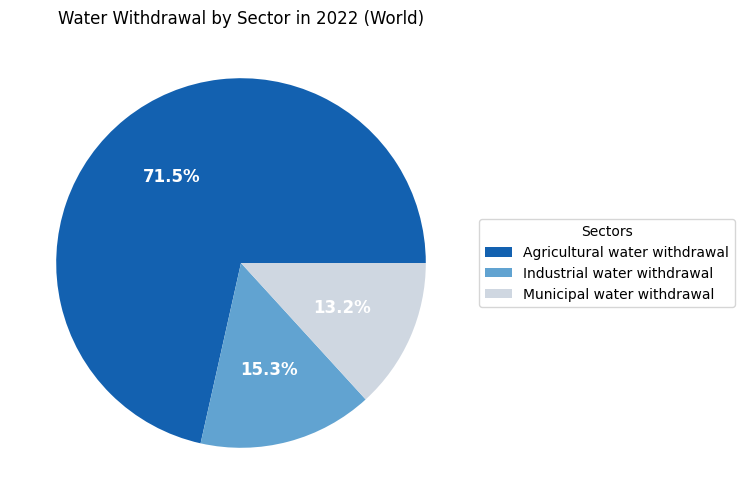

In [12]:
colors = ["#1361B0", "#61A3D1", "#CFD7E1"]

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))

data = selected_values
labels = selected_variables

# Add autopct to display percentages inside the pie
wedges, texts, autotexts = ax.pie(
    data,
    colors=colors,
    textprops=dict(color="w"),
    autopct='%1.1f%%'  # This adds the percentage labels
)

ax.legend(wedges, labels,
          title="Sectors",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(texts, size=12, weight="bold")
plt.setp(autotexts, size=12, weight="bold")  # Style the percentage labels

ax.set_title("Water Withdrawal by Sector in 2022 (World)")

### How much land is it used for food production?

In [13]:
filter_landuse_data = landuse_data["Item"].unique()
print("Unique Land Use Items:", filter_landuse_data)

Unique Land Use Items: ['Country area' 'Land area' 'Agriculture' 'Agricultural land' 'Cropland'
 'Arable land' 'Temporary crops' 'Temporary meadows and pastures'
 'Temporary fallow' 'Permanent crops' 'Permanent meadows and pastures'
 'Forest land' 'Naturally regenerating forest' 'Planted Forest'
 'Other land' 'Inland waters' 'Land area equipped for irrigation'
 'Agriculture area under organic agric.' 'Primary Forest']


In [14]:
# Filter the land use data
filtered_landuse = landuse_data[
    (landuse_data["Area"] == "World") &
    (landuse_data["Year"] == 2018) &
    (landuse_data["Element"] == "Area") &
    (landuse_data["Item"].isin(["Country land",
                                "Land area", 
                                "Agriculture", 
                                "Forest land", 
                                "Land used for aquaculture", 
                                "Inland waters used for aquac. or holding facilities", 
                                "Inland waters used for capture fishes", 
                                "Coastal waters used for aquac. or holding facilities",
                                "Coastal waters used for capture fishes",
                                "EEZ used for aquac. or holding facilities",
                                "EEZ used for capture fishes"]))
]

filtered_landuse = filtered_landuse[["Area", "Year", "Item", "Value"]]
filtered_landuse

,Area,Year,Item,Value
44,World,2018,Land area,1.303152e+07
69,World,2018,Agriculture,4.841329e+06
532,World,2018,Forest land,4.068924e+06


In [15]:
land_area = filtered_landuse[(filtered_landuse["Item"] == "Land area")]["Value"].iloc[0]
agriculture_area = filtered_landuse[(filtered_landuse["Item"] == "Agriculture")]["Value"].iloc[0]
forest_land_area = filtered_landuse[(filtered_landuse["Item"] == "Forest land")]["Value"].iloc[0]
other_land_area = land_area - (agriculture_area + forest_land_area)

# percentage of land used for agriculture
agriculture_percentage = (agriculture_area / land_area) * 100
forest_land_area_percentage = (forest_land_area / land_area) * 100
other_land_area_percentage = (other_land_area / land_area) * 100
print(f"Percentage of land used for agriculture: {agriculture_percentage:.2f}%")
print(f"Percentage of land used for forest: {forest_land_area_percentage:.2f}%")
print(f"Percentage of other land use: {other_land_area_percentage:.2f}%")

Percentage of land used for agriculture: 37.15%
Percentage of land used for forest: 31.22%
Percentage of other land use: 31.63%


Text(0.5, 1.0, 'Land use by Sector in 2022 (World)')

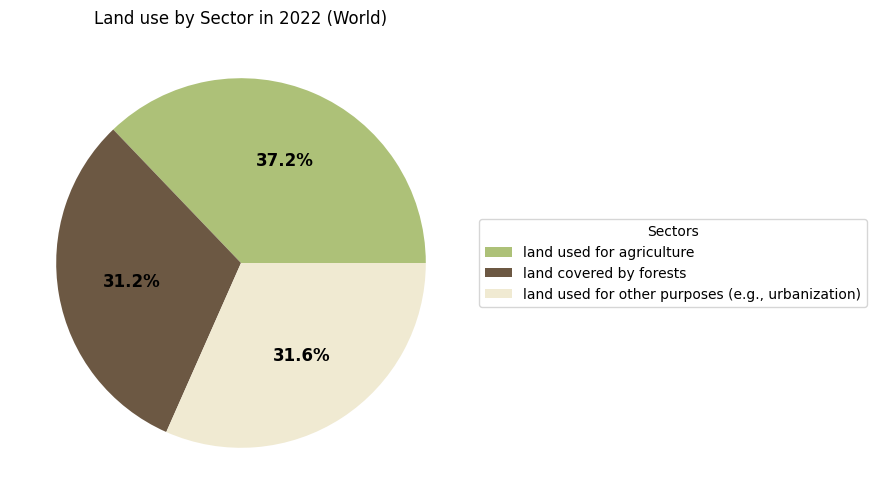

In [16]:
labels = ["land used for agriculture", "land covered by forests", "land used for other purposes (e.g., urbanization)"]
sizes = [agriculture_area, forest_land_area, other_land_area]
colors = ["#ADC178", "#6C5843", "#F0EAD2"]

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))

data = sizes

# Add autopct to display percentages inside the pie
wedges, texts, autotexts = ax.pie(
    data,
    colors=colors,
    autopct='%1.1f%%'  # This adds the percentage labels
)

ax.legend(wedges, labels,
          title="Sectors",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(texts, size=12, weight="bold")
plt.setp(autotexts, size=12, weight="bold")  # Style the percentage labels

ax.set_title("Land use by Sector in 2022 (World)")

### What are the emissions of the agricultural sector compared to other sectors?

In [17]:
fao_greenhouse_gas_emissions

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Source Code,Source,Unit,Value,Flag,Flag Description,Note
0,GT,Emissions totals,1,World,7234,Direct emissions (N2O),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,425.3989,E,Estimated value,NaN
1,GT,Emissions totals,1,World,7236,Indirect emissions (N2O),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,95.7152,E,Estimated value,NaN
2,GT,Emissions totals,1,World,7230,Emissions (N2O),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,521.1148,E,Estimated value,NaN
3,GT,Emissions totals,1,World,724313,Emissions (CO2eq) from N2O (AR5),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,138095.4220,E,Estimated value,NaN
4,GT,Emissions totals,1,World,723113,Emissions (CO2eq) (AR5),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,138095.4220,E,Estimated value,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,GT,Emissions totals,1,World,7230,Emissions (N2O),6819,Other,2022,2022,3050,FAO TIER 1,kt,601.7354,E,Estimated value,NaN
3620,GT,Emissions totals,1,World,7273,Emissions (CO2),6819,Other,2022,2022,3050,FAO TIER 1,kt,47500.3188,E,Estimated value,NaN
3621,GT,Emissions totals,1,World,724413,Emissions (CO2eq) from CH4 (AR5),6819,Other,2022,2022,3050,FAO TIER 1,kt,4218.9272,E,Estimated value,NaN
3622,GT,Emissions totals,1,World,724313,Emissions (CO2eq) from N2O (AR5),6819,Other,2022,2022,3050,FAO TIER 1,kt,159459.8941,E,Estimated value,NaN


In [18]:
fao_greenhouse_gas_emissions["Item"].unique()

array(['Crop Residues', 'Rice Cultivation', 'Burning - Crop residues',
       'Enteric Fermentation', 'Manure Management',
       'Manure left on Pasture', 'Manure applied to Soils',
       'Synthetic Fertilizers', 'Drained organic soils',
       'Drained organic soils (CO2)', 'Drained organic soils (N2O)',
       'On-farm energy use', 'Forestland', 'Net Forest conversion',
       'Savanna fires', 'Fires in organic soils', 'Forest fires',
       'Fires in humid tropical forests',
       'Agrifood Systems Waste Disposal', 'Fertilizers Manufacturing',
       'Pesticides Manufacturing', 'Food Processing', 'Food Packaging',
       'Food Retail', 'Food Household Consumption', 'Food Transport',
       'Energy', 'IPPU', 'Waste', 'International bunkers', 'Other'],
      dtype=object)

In [19]:
aggregation_map = {
    # Crop Production
    'Crop Residues': 'Crop Production',
    'Rice Cultivation': 'Crop Production',
    'Burning - Crop residues': 'Crop Production',
    'Synthetic Fertilizers': 'Crop Production',
    'Drained organic soils': 'Crop Production',
    'Drained organic soils (CO2)': 'Crop Production',
    'Drained organic soils (N2O)': 'Crop Production',
    'Manure applied to Soils': 'Crop Production',

    # Livestock Production
    'Enteric Fermentation': 'Livestock Production',
    'Manure Management': 'Livestock Production',
    'Manure left on Pasture': 'Livestock Production',

    # Land-Use Change
    'Forestland': 'Land-Use Change',
    'Net Forest conversion': 'Land-Use Change',
    'Savanna fires': 'Land-Use Change',
    'Fires in organic soils': 'Land-Use Change',
    'Forest fires': 'Land-Use Change',
    'Fires in humid tropical forests': 'Land-Use Change',

    # On-Farm Energy
    'On-farm energy use': 'On-Farm Energy',

    # Agricultural Inputs
    'Fertilizers Manufacturing': 'Ag. Inputs Manufacturing',
    'Pesticides Manufacturing': 'Ag. Inputs Manufacturing',

    # Processing & Packaging
    'Food Processing': 'Processing & Packaging',
    'Food Packaging': 'Processing & Packaging',

    # Transport & Retail
    'Food Transport': 'Transport & Retail',
    'Food Retail': 'Transport & Retail',

    # Consumption
    'Food Household Consumption': 'Consumption',

    # Waste
    'Agrifood Systems Waste Disposal': 'Waste',

    # Exclude or label as "Other" if unrelated
    'Energy': 'Other',
    'IPPU': 'Other',
    'Waste': 'Other',
    'International bunkers': 'Other',
    'Other': 'Other'
}

fao_greenhouse_gas_emissions['Category'] = fao_greenhouse_gas_emissions['Item'].map(aggregation_map)

fao_greenhouse_gas_emissions


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Source Code,Source,Unit,Value,Flag,Flag Description,Note,Category
0,GT,Emissions totals,1,World,7234,Direct emissions (N2O),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,425.3989,E,Estimated value,NaN,Crop Production
1,GT,Emissions totals,1,World,7236,Indirect emissions (N2O),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,95.7152,E,Estimated value,NaN,Crop Production
2,GT,Emissions totals,1,World,7230,Emissions (N2O),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,521.1148,E,Estimated value,NaN,Crop Production
3,GT,Emissions totals,1,World,724313,Emissions (CO2eq) from N2O (AR5),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,138095.4220,E,Estimated value,NaN,Crop Production
4,GT,Emissions totals,1,World,723113,Emissions (CO2eq) (AR5),5064,Crop Residues,1999,1999,3050,FAO TIER 1,kt,138095.4220,E,Estimated value,NaN,Crop Production
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,GT,Emissions totals,1,World,7230,Emissions (N2O),6819,Other,2022,2022,3050,FAO TIER 1,kt,601.7354,E,Estimated value,NaN,Other
3620,GT,Emissions totals,1,World,7273,Emissions (CO2),6819,Other,2022,2022,3050,FAO TIER 1,kt,47500.3188,E,Estimated value,NaN,Other
3621,GT,Emissions totals,1,World,724413,Emissions (CO2eq) from CH4 (AR5),6819,Other,2022,2022,3050,FAO TIER 1,kt,4218.9272,E,Estimated value,NaN,Other
3622,GT,Emissions totals,1,World,724313,Emissions (CO2eq) from N2O (AR5),6819,Other,2022,2022,3050,FAO TIER 1,kt,159459.8941,E,Estimated value,NaN,Other


In [ ]:
useless_drained_organic_soil = [
    "Drained organic soils (CO2)", "Drained organic soils (N2O)"
]

# Select rows for agriculture sectors emissions
agriculture_sectors_emissions = fao_greenhouse_gas_emissions[(fao_greenhouse_gas_emissions["Category"] != "Other") & 
                                                             (fao_greenhouse_gas_emissions["Area"] == "World") &
                                                                (fao_greenhouse_gas_emissions["Year"] == 2022) &
                                                             (fao_greenhouse_gas_emissions["Element"] == "Emissions (CO2eq) (AR5)")]

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Source Code,Source,Unit,Value,Flag,Flag Description,Note,Category
119,GT,Emissions totals,1,World,723113,Emissions (CO2eq) (AR5),5064,Crop Residues,2022,2022,3050,FAO TIER 1,kt,1.955464e+05,E,Estimated value,NaN,Crop Production
191,GT,Emissions totals,1,World,723113,Emissions (CO2eq) (AR5),5060,Rice Cultivation,2022,2022,3050,FAO TIER 1,kt,6.827550e+05,E,Estimated value,NaN,Crop Production
311,GT,Emissions totals,1,World,723113,Emissions (CO2eq) (AR5),5066,Burning - Crop residues,2022,2022,3050,FAO TIER 1,kt,3.755291e+04,E,Estimated value,NaN,Crop Production
383,GT,Emissions totals,1,World,723113,Emissions (CO2eq) (AR5),5058,Enteric Fermentation,2022,2022,3050,FAO TIER 1,kt,2.905329e+06,E,Estimated value,NaN,Livestock Production
551,GT,Emissions totals,1,World,723113,Emissions (CO2eq) (AR5),5059,Manure Management,2022,2022,3050,FAO TIER 1,kt,3.976728e+05,E,Estimated value,NaN,Livestock Production
671,GT,Emissions totals,1,World,723113,Emissions (CO2eq) (AR5),5063,Manure left on Pasture,2022,2022,3050,FAO TIER 1,kt,7.929143e+05,E,Estimated value,NaN,Livestock Production
791,GT,Emissions totals,1,World,723113,Emissions (CO2eq) (AR5),5062,Manure applied to Soils,2022,2022,3050,FAO TIER 1,kt,1.639615e+05,E,Estimated value,NaN,Crop Production
887,GT,Emissions totals,1,World,723113,Emissions (CO2eq) (AR5),5061,Synthetic Fertilizers,2022,2022,3050,FAO TIER 1,kt,5.962305e+05,E,Estimated value,NaN,Crop Production
911,GT,Emissions totals,1,World,723113,Emissions (CO2eq) (AR5),6729,Drained organic soils,2022,2022,3050,FAO TIER 1,kt,9.225129e+05,E,Estimated value,NaN,Crop Production
959,GT,Emissions totals,1,World,723113,Emissions (CO2eq) (AR5),67292,Drained organic soils (CO2),2022,2022,3050,FAO TIER 1,kt,8.300704e+05,E,Estimated value,NaN,Crop Production


In [21]:
# Remove rows with "Dried organic soils (CO2)" and "Dried organic soils (N2O)"
agriculture_sectors_emissions = agriculture_sectors_emissions[~agriculture_sectors_emissions["Item"].isin(useless_drained_organic_soil)] # Pietro use this
# Group by Category and sum the values
agriculture_sectors_emissions = agriculture_sectors_emissions.groupby("Category").agg({
    "Domain": "first",  # Keep the first value (assuming all rows have the same value)
    "Area": "first",   # Keep the first value (assuming all rows have the same value)
    "Element": "first",  # Keep the first value (assuming all rows have the same value)
    "Year": "first",  # Keep the first value (assuming all rows have the same value)
    "Unit": "first",  # Keep the first value (assuming all rows have the same value)
    "Value": "sum",  # Sum the values
    "Flag Description": "first"  # Keep the first value (assuming all rows have the same value)
}).reset_index()


In [22]:
# Rename category column as "Item"
agriculture_sectors_emissions.rename(columns={"Category": "Item"}, inplace=True)

# Add a new column category column filled with "Agrifood System"
agriculture_sectors_emissions["Category"] = "Agrifood System"

In [ ]:
agriculture_sectors_emissions # Pietro usa questo

,Item,Domain,Area,Element,Year,Unit,Value,Flag Description,Category
0,Ag. Inputs Manufacturing,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,5.550382e+05,Estimated value,Agrifood System
1,Consumption,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,1.204485e+06,Estimated value,Agrifood System
2,Crop Production,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,2.598559e+06,Estimated value,Agrifood System
3,Land-Use Change,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,7.976751e+05,Estimated value,Agrifood System
4,Livestock Production,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,4.095916e+06,Estimated value,Agrifood System
5,On-Farm Energy,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,9.284939e+05,Estimated value,Agrifood System
6,Processing & Packaging,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,9.753780e+05,Estimated value,Agrifood System
7,Transport & Retail,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,1.317908e+06,Estimated value,Agrifood System
8,Waste,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,1.281260e+06,Estimated value,Agrifood System


In [24]:
agriculture_sectors_emissions_values = agriculture_sectors_emissions["Value"].tolist()
agriculture_sectors_emissions_items = agriculture_sectors_emissions["Item"].tolist()

In [ ]:
# Filter for other sectors emissions
Other_sectors_emissions = fao_greenhouse_gas_emissions[(fao_greenhouse_gas_emissions["Category"] == "Other") &
                                                        (fao_greenhouse_gas_emissions["Area"] == "World") &
                                                        (fao_greenhouse_gas_emissions["Year"] == 2022) &
                                                        (fao_greenhouse_gas_emissions["Element"] == "Emissions (CO2eq) (AR5)")]

# Remove columns that are not needed
Other_sectors_emissions = Other_sectors_emissions[["Item", "Domain", "Area", "Element", "Year", "Unit", "Value", "Flag Description", "Category"]]

Other_sectors_emissions # Pietro usa questo

,Item,Domain,Area,Element,Year,Unit,Value,Flag Description,Category
3023,Energy,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,3.884379e+07,Estimated value,Other
3191,IPPU,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,4.500829e+06,Estimated value,Other
3335,Waste,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,2.577948e+06,Estimated value,Other
3479,International bunkers,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,1.175800e+06,Estimated value,Other
3623,Other,Emissions totals,World,Emissions (CO2eq) (AR5),2022,kt,2.111791e+05,Estimated value,Other


In [26]:
other_sectors_emissions_values = Other_sectors_emissions["Value"].tolist()
other_sectors_emissions_items = Other_sectors_emissions["Item"].tolist()

In [35]:
# List with all the categories
categories = []

for item in other_sectors_emissions_items:
    categories.append(item)

# Insert "Agrifood System" as the first item in the categories list
categories.insert(1, "Agrifood System")

print("Categories:", categories)

Categories: ['Energy', 'Agrifood System', 'IPPU', 'Waste', 'International bunkers', 'Other']


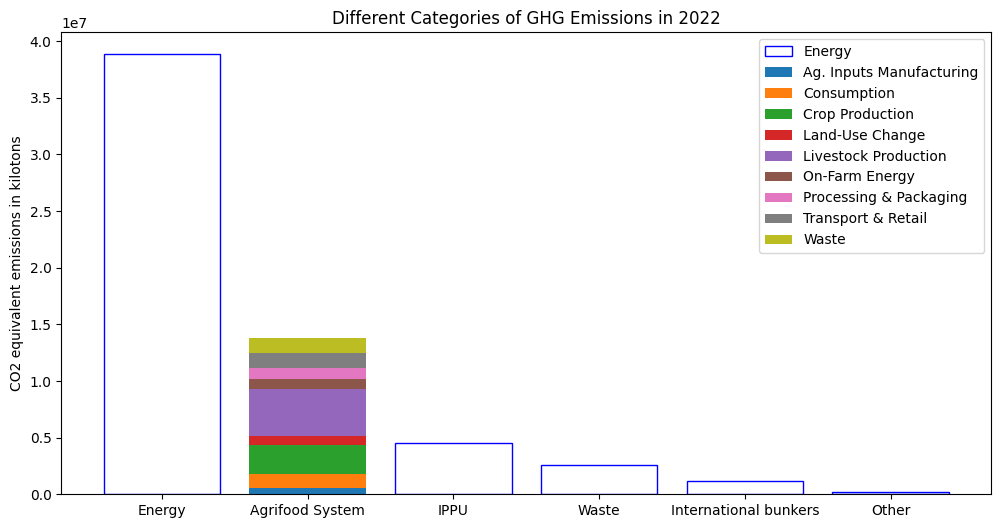

In [36]:
x = np.arange(len(categories))  # the label locations

fig, ax = plt.subplots(figsize=(12, 6))

single_bar_color = "b"
face_color = "white"

# First bar for energy sector
ax.bar(x[0], other_sectors_emissions_values[0], label=other_sectors_emissions_items[0], color=face_color, edgecolor=single_bar_color)

# Only stack for the agriculture sectors
i = 0
while i < len(agriculture_sectors_emissions_values):
    if i == 0:
        ax.bar(x[1], agriculture_sectors_emissions_values[i], label=agriculture_sectors_emissions_items[i])
        bottom = agriculture_sectors_emissions_values[i]
        i += 1
    else:
        ax.bar(x[1], agriculture_sectors_emissions_values[i], label=agriculture_sectors_emissions_items[i], bottom=bottom)
        bottom += agriculture_sectors_emissions_values[i]
        i += 1

k = 2  # Start from the second index for other sectors
j = 1
while j < len(other_sectors_emissions_values):
    ax.bar(x[k], other_sectors_emissions_values[j], label=None, color=face_color, edgecolor=single_bar_color)
    k += 1
    j += 1

plt.xticks(x, categories)
plt.ylabel('CO2 equivalent emissions in kilotons')
plt.title("Different Categories of GHG Emissions in 2022")
plt.legend()
plt.show()


## Which are the most consumed types of food in Italy?

In [ ]:
# Group by 'Exposure hierarchy (L7)', sum the 'Mean' values, and get the top 15
food_consumption_data_nowater = food_consumption_data[
    (food_consumption_data["Exposure hierarchy (L7)"] != "Natural mineral water") &
    (food_consumption_data["Exposure hierarchy (L7)"] != "Tap water") &
    (food_consumption_data["Exposure hierarchy (L7)"] != "Filtered tap water")]

top15 = (
    food_consumption_data_nowater
    .groupby('Exposure hierarchy (L7)', as_index=False)['Mean']
    .sum()
    .sort_values('Mean', ascending=False)
    .head(15)
)

# Extract lists
selected_variables = top15["Exposure hierarchy (L7)"].tolist()
selected_values = top15["Mean"].tolist()

# Create a bar plot for the top 15 food items
plt.figure(figsize=(10, 6))
plt.barh(selected_variables, selected_values, color='skyblue')
plt.xlabel('Mean Consumption')
plt.title('Top 15 Food Items by Mean Consumption')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
plt.tight_layout()
plt.show()

### Merging datasets one after the other